In [1]:
# imports
import json
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 10)

In [2]:
CLASSES = ['gametocyte', 'leukocyte', 'red blood cell', 'ring', 'schizont', 'trophozoite', 'difficult']

In [3]:
def parse_json(data_json):
    csv_data = []
    widths = []
    heights = []
    obj_widths = []
    obj_heights = []
    objs_per_image = []
    num_classes = OrderedDict([(c, 0) for c in CLASSES])

    for img in data_json:
        num_objects = 0
        widths.append(img['image']['shape']['c'])
        heights.append(img['image']['shape']['r'])

        path = img['image']['pathname']
        if path[0] == '/': path = path[1:]

        for obj in img['objects']:
            class_name = obj['category']
            # if class_name == 'difficult': continue

            num_classes[class_name] += 1
            num_objects += 1

            x1, y1 = obj['bounding_box']['minimum']['c'], obj['bounding_box']['minimum']['r']
            x2, y2 = obj['bounding_box']['maximum']['c'], obj['bounding_box']['maximum']['r']
            csv_data.append((path, x1, y1, x2, y2, class_name))

            obj_widths.append(x2 - x1)
            obj_heights.append(y2 - y1)

        objs_per_image.append(num_objects)

    return csv_data, np.array(widths), np.array(heights), np.array(obj_widths), np.array(obj_heights), np.array(objs_per_image), num_classes

In [4]:
with open('datasets/malaria/training.json') as f:
    train_json = json.load(f)
with open('datasets/malaria/test.json') as f:
    test_json = json.load(f)

In [5]:
validation_split = 0.2
train_split_json, val_split_json = train_test_split(train_json, test_size=validation_split, random_state=6)

In [6]:
csv_data_train_all, *_ = parse_json(train_json)
csv_data_train, widths_train, heights_train, obj_widths_train, obj_heights_train, objs_per_image_train, num_classes_train = parse_json(train_split_json)
csv_data_val, widths_val, heights_val, obj_widths_val, obj_heights_val, objs_per_image_val, num_classes_val = parse_json(val_split_json)
csv_data_test, widths_test, heights_test, obj_widths_test, obj_heights_test, objs_per_image_test, num_classes_test = parse_json(test_json)

In [7]:
# Create csv files
def write_csv(data, file_path):
    with open(file_path, 'w') as f:
        for d in data:
            f.write(','.join(map(str, d)))
            f.write('\n')

write_csv(csv_data_train_all, 'datasets/malaria/train_all.csv')
write_csv(csv_data_train, 'datasets/malaria/train.csv')
write_csv(csv_data_val, 'datasets/malaria/val.csv')
write_csv(csv_data_test, 'datasets/malaria/test.csv')
write_csv(zip(CLASSES, range(len(CLASSES))), 'datasets/malaria/classes.csv')

In [8]:
print(f'Train images size: ({np.mean(widths_train)}±{np.std(widths_train)})*({np.mean(heights_train)}±{np.std(heights_train)})')
print(f'Val images size: ({np.mean(widths_val)}±{np.std(widths_val)})*({np.mean(heights_val)}±{np.std(heights_val)})')
print(f'Test images size: ({np.mean(widths_test)}±{np.std(widths_test)})*({np.mean(heights_test)}±{np.std(heights_test)})')

Train images size: (1600.0±0.0)*(1200.0±0.0)
Val images size: (1600.0±0.0)*(1200.0±0.0)
Test images size: (1944.0±0.0)*(1383.0±0.0)


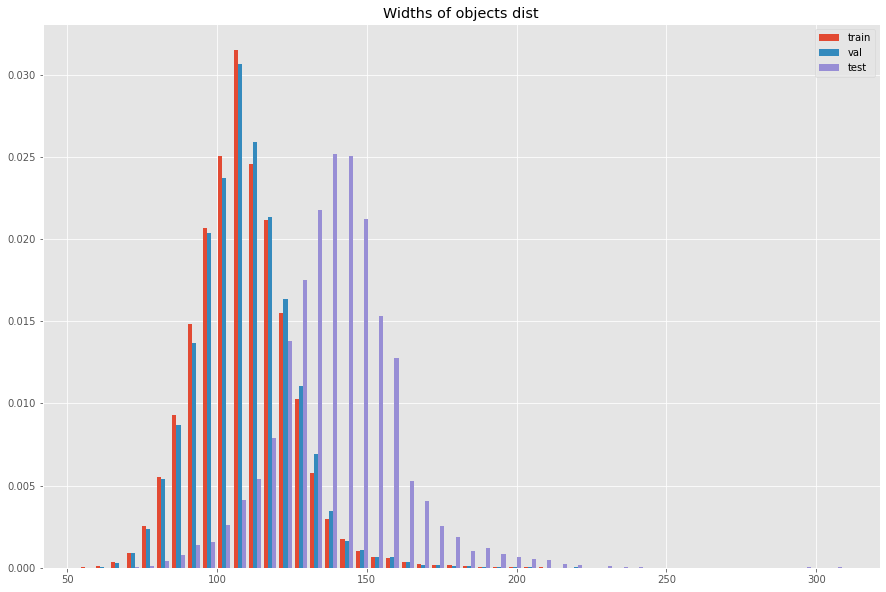

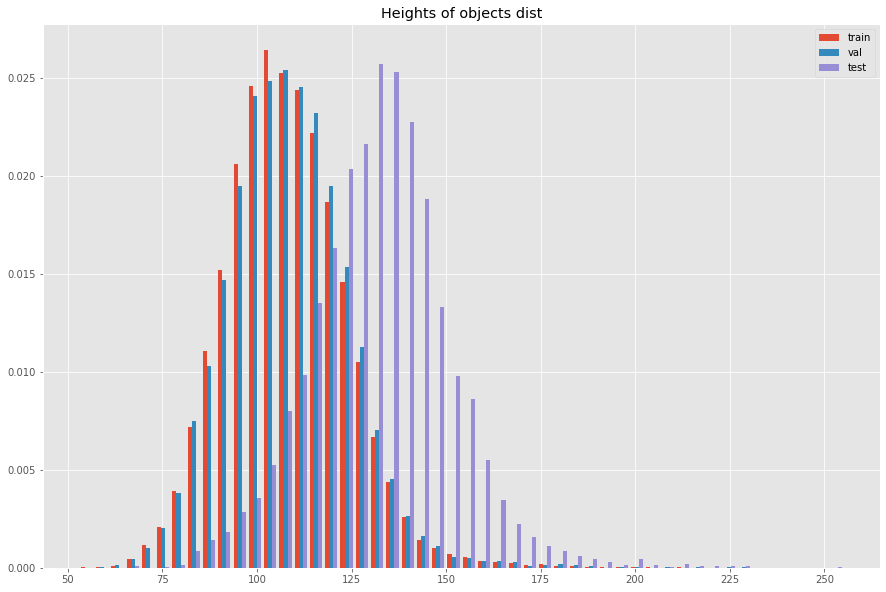

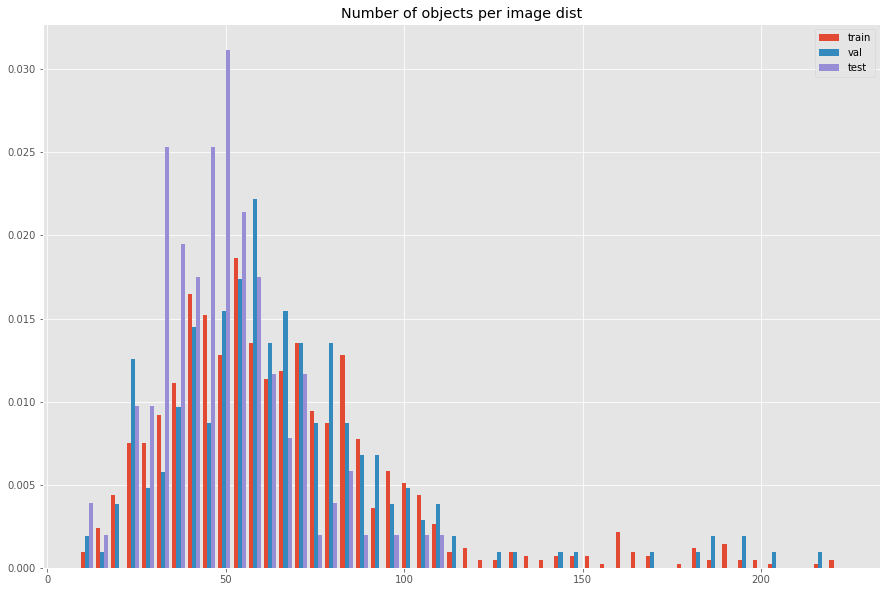

In [9]:
plt.hist([obj_widths_train, obj_widths_val, obj_widths_test], bins=50, density=True, label=['train', 'val', 'test'])
plt.title('Widths of objects dist')
plt.legend(loc='upper right')
plt.show()

plt.title('Heights of objects dist')
plt.hist([obj_heights_train, obj_heights_val, obj_heights_test], bins=50, density=True, label=['train', 'val', 'test'])
plt.legend(loc='upper right')
plt.show()

plt.title('Number of objects per image dist')
plt.hist([objs_per_image_train, objs_per_image_val, objs_per_image_test], bins=50, density=True, label=['train', 'val', 'test'])
plt.legend(loc='upper right')
plt.show()

In [10]:
print(num_classes_train.values())
print(num_classes_val.values())

odict_values([108, 81, 62016, 287, 137, 1180, 354])
odict_values([36, 22, 15404, 66, 42, 293, 87])


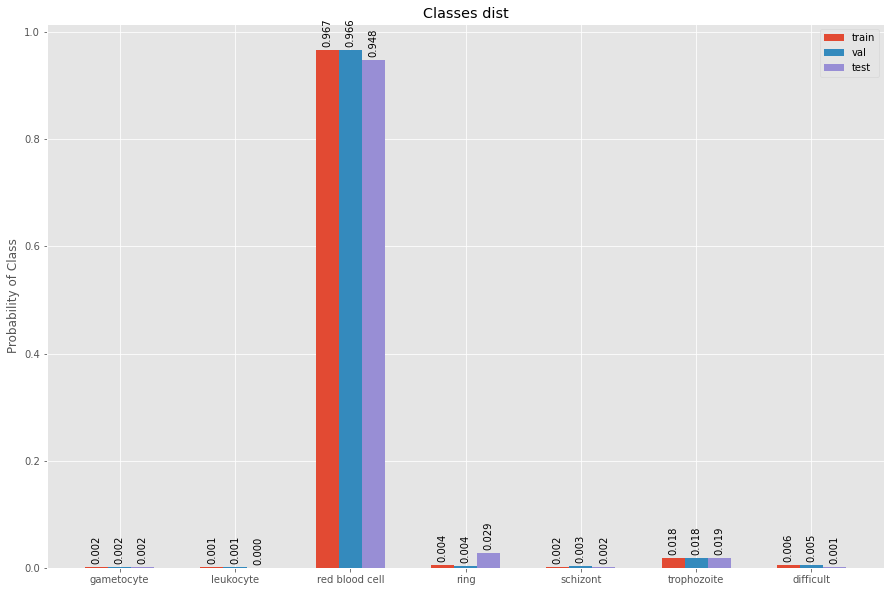

In [11]:
x = np.arange(len(CLASSES))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects = []
for dist, label, offset in zip([num_classes_train, num_classes_val, num_classes_test], ['train', 'val', 'test'], [-width, 0, width]):
    num_data = sum(dist.values())
    height = np.array(list(dist.values())) / num_data
    rects.append(ax.bar(x + offset, height, width, label=label))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Probability of Class')
ax.set_title('Classes dist')
ax.set_xticks(x)
ax.set_xticklabels(CLASSES)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.03f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', rotation=90)
for rect in rects:
    autolabel(rect)

plt.show()